In [1]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [2]:
leaf_pixel_x = 25
leaf_pixel_y = 25
start_band = 108
end_band = 138
band_delta = end_band - start_band
band_range = bands[start_band:end_band]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

rois_old = np.empty((6, 50, 50, band_delta))
for i in range(1, 3):
    current_rois = np.load("rois_old{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_old = np.append(rois_old, current_rois, axis=0)

rois_old.shape

(18, 50, 50, 30)

In [4]:
rois_young = np.empty((6, 50, 50, band_delta))
for i in range(1, 3):
    current_rois = np.load("rois_young{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_young = np.append(rois_young, current_rois, axis=0)
    
rois_young.shape

(18, 50, 50, 30)

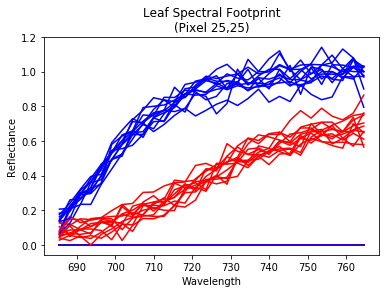

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(1, rois_young.shape[0]):
    leaf_pixel = rois_old[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed, 'r')
    
    leaf_pixel = rois_young[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed ,'b')

plt.title('Leaf Spectral Footprint\n(Pixel {},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show([-100, 100])

In [6]:
from sklearn.model_selection import train_test_split

X = np.append(rois_old, rois_young, axis=0)
y = np.append(np.ones(18), np.zeros(18))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

X.shape, y.shape

((36, 50, 50, 30), (36,))

In [7]:
from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (50, 50, band_delta), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 2, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Train on 30 samples, validate on 6 samples
Epoch 1/50
30/30 [==============================] - 3s 110ms/step - loss: 0.6547 - acc: 0.5333 - val_loss: 2.4328 - val_acc: 0.3333
Epoch 2/50
30/30 [==============================] - 0s 1ms/step - loss: 1.2083 - acc: 0.5333 - val_loss: 0.8791 - val_acc: 0.1667
Epoch 3/50
30/30 [==============================] - 0s 911us/step - loss: 0.5866 - acc: 0.6000 - val_loss: 0.4392 - val_acc: 0.8333
Epoch 4/50
30/30 [==============================] - 0s 752us/step - loss: 0.6530 - acc: 0.4667 - val_loss: 0.4509 - val_acc: 0.8333
Epoch 5/50
30/30 [==============================] - 0s 666us/step - loss: 0.5204 - acc: 0.8667 - val_loss: 0.5956 - val_acc: 0.3333
Epoch 6/50
30/30 [==============================] - 0s 610us/step - loss: 0.4455 - acc: 0.6667 - val_loss: 0.6329 - val_acc: 0.3333
Epoch 7/50
30/30 [==============================] - 0s 641us/step - loss: 0.4406 - acc: 0.6333 - val_loss: 0.4136 - val_acc: 0.8333
Epoch 8/50
30/30 [=================

In [10]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15493528544902802
Test accuracy: 0.8333333134651184


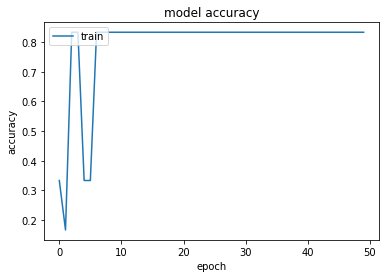

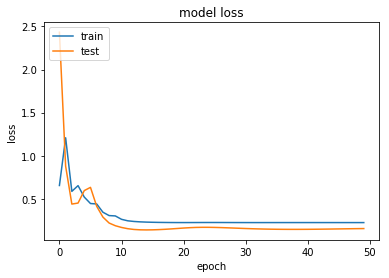

In [11]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model.predict(X_test[:])

array([[1.0000000e+00, 0.0000000e+00],
       [5.9604645e-08, 1.0317224e-01],
       [4.4703484e-07, 3.2583773e-02],
       [1.8179417e-06, 1.0510117e-02],
       [8.6426735e-07, 3.2182187e-02],
       [3.6228028e-01, 5.5536932e-01]], dtype=float32)